In [13]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
import torch.nn.functional as F
import pandas as pd

In [14]:
# Read data from CSV file
file_path = "./my_data3.csv"
my_data = pd.read_csv(file_path)[["number", "construction", "sentence", "item", "grammaticality"]].drop_duplicates()

lengths = []
for sentence in my_data["sentence"]:
  lengths.append(len(sentence.split()))

my_data["num_words"] = lengths

my_data

,number,construction,sentence,item,grammaticality,num_words
0,0,p_pn,The laws have done,any,0,4
1,1,p_pn,Many of the laws have done,any,0,6
2,2,p_pn,It is the case that the laws have done,any,0,9
3,3,p_prel,The laws which I have studied have done,any,0,8
4,4,p_prel,Many of the laws which I have studied have done,any,0,10
...,...,...,...,...,...,...
1975,1975,n_nrel,None of the passengers which I have not have s...,any,1,11
1976,1976,n_nrel,It is not the case that the passengers which I...,any,1,14
1977,1977,n_npp,No passengers in none of these places impress,any,1,8
1978,1978,n_npp,None of the passengers in none of these places...,any,1,10


In [15]:
# Load GPT model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

mask_id = tokenizer.mask_token_id
mask = tokenizer.mask_token

def my_test(model, tokenizer, my_data):
    my_data["prob"] = None
    model.eval()
    # Loop through data
    for index, row in my_data.iterrows():
        sentence = row["sentence"]
        #sentence = f"[CLS] {sentence} [SEP]"
        encoded_input = tokenizer(sentence, return_tensors='pt')
        outputs = model(**encoded_input, labels=encoded_input["input_ids"])
        probs = F.softmax(outputs.logits[:,-1,:], dim=1).squeeze()
        my_data.at[index, "prob"] = probs[tokenizer.convert_tokens_to_ids('Ġ' + row["item"])].item()

my_test(model, tokenizer, my_data)

Using mask_token, but it is not set yet.


In [18]:
def my_get_accs(my_data):
    if "prob" not in my_data:
        print("Run test to get the model predictions (or make sure your test is working!)")

    accs = {}
    constructions = my_data["construction"].unique()

    for construct in constructions:
        restriction = my_data[my_data["construction"] == construct]
        if len(restriction) > 0:
            total_prob = sum(restriction["prob"])
            accs[construct] = total_prob / len(restriction)
        else:
            accs[construct] = 0.0

    return accs

my_accs = my_get_accs(my_data)

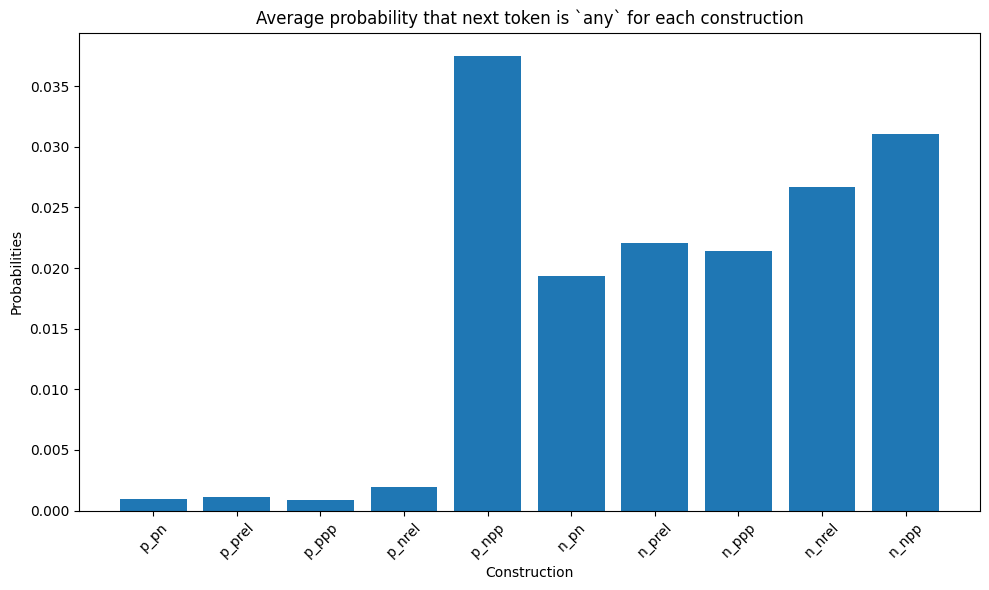

p_pn: 0.0009249%
p_prel: 0.001091%
p_ppp: 0.0008884%
p_nrel: 0.001963%
p_npp: 0.03751%
n_pn: 0.01935%
n_prel: 0.02207%
n_ppp: 0.02144%
n_nrel: 0.02667%
n_npp: 0.03103%


In [20]:
df = pd.DataFrame(list(my_accs.items()), columns=['Keys', 'Values'])

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(df['Keys'], df['Values'])
plt.xlabel('Construction')
plt.ylabel('Probabilities')
plt.title('Average probability that next token is `any` for each construction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

for construction,my_acc in my_accs.items():
  print("{}: {:.4}%".format(construction, my_acc))

# Save results to a CSV file
file_path = "results-gpt.csv"
my_data.to_csv(file_path, index=False)